# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
# импорт библиотек
import pandas as pd

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# загрузка данных
try:
    data = pd.read_csv('/datasets/users_behavior.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
# изучение общей информации таблиц будем делать по сценарию
def show_info(table):
    
    # общая информация
    table.info()
    
    # проверка наименований столбцов
    print('\nНаименования столбцов:')
    print(table.columns)
    
    # пропущенные значения
    print('\nПропущенные значения:')
    total_entries = table.shape[0]
    na_columns = table.isnull().sum().reset_index().rename(columns = {'index': 'column', 0: 'nan_qty'}, inplace = False)
    na_columns['na_percent'] = round((na_columns['nan_qty'] / total_entries * 100), 1)
    display(na_columns)
    
    # полные дубликаты
    print('\nПолные дубликаты:', table.duplicated().sum())
    
    # голова таблицы
    print('\nНачало таблицы данных:')
    display(table.head(5))

In [4]:
show_info(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB

Наименования столбцов:
Index(['calls', 'minutes', 'messages', 'mb_used', 'is_ultra'], dtype='object')

Пропущенные значения:


,column,nan_qty,na_percent
0,calls,0,0.0
1,minutes,0,0.0
2,messages,0,0.0
3,mb_used,0,0.0
4,is_ultra,0,0.0



Полные дубликаты: 0

Начало таблицы данных:


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


### Вывод по общим данным файла
По условиям задача предобрабока данных считается выполненной (в предыдущих работах).  

Данные содержат 3214 записи.  
Наименования столбцов корректны.  
Пропущенных данных не обнаружено. 
Типы данных корректны.  
Полных (явных) дубликатов не обнаружено.  

**Описание данных**  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

### Выделение признаков модели
Разрабатываемая модель должна отвечать на вопрос какой из двух тарифов `"Смарт"` или `"Ультра"` подходит клиенту на основе его истории поведения.  
Таким образом мы имеем дело с задачей *бинарной классификации*.  

**Признаки**
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб  

**Целевой признак**
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

In [5]:
# признаки
features = data.drop(['is_ultra'], axis=1)

# целевой признак
target = data['is_ultra']

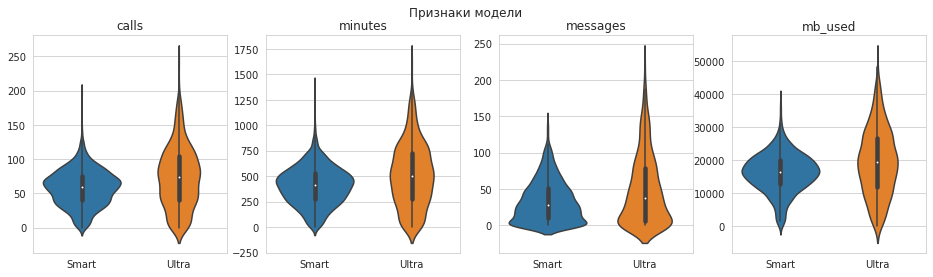

In [6]:
# признаки графически
sns.set_style("whitegrid")

feature_names = features.columns
target_name = 'is_ultra'

fig, axes = plt.subplots(1, len(feature_names), figsize = (16, 4));
fig.suptitle('Признаки модели')

i = 0
for feature_name in feature_names:
    v = sns.violinplot(x= target_name, y= feature_name, split= True, data= data, ax= axes[i]);
    v.set_title(feature_name)
    v.set_ylabel("")
    v.set_xlabel("")
    v.set_xticklabels(['Smart','Ultra'])
    i += 1

plt.show();

**Тариф Smart**

In [7]:
print("Тариф Smart")
display(data
        .query('is_ultra == 0')[feature_names]
        .apply (['count', 'min', 'max', 'median'])
        .style.format("{:,.2f}")
       )

Тариф Smart


,calls,minutes,messages,mb_used
count,"2,229.00","2,229.00","2,229.00","2,229.00"
min,0.00,0.00,0.00,0.00
max,198.00,"1,390.22",143.00,"38,552.62"
median,60.00,410.56,28.00,"16,506.93"


**Тариф Ultra**

In [8]:
print("Тариф Ultra")
display(data
        .query('is_ultra == 1')[feature_names]
        .apply (['count', 'min', 'max', 'median'])   
        .style.format("{:,.2f}")
       )

Тариф Ultra


,calls,minutes,messages,mb_used
count,985.00,985.00,985.00,985.00
min,0.00,0.00,0.00,0.00
max,244.00,"1,632.06",224.00,"49,745.73"
median,74.00,502.55,38.00,"19,308.01"


**Корреляция между параметрами и тарифным планом**

In [9]:
features_corr = pd.DataFrame(columns= ['feature_name','feature_correlation'])

for feature_name in feature_names:
    correlation = data[feature_name].corr(data[target_name])
    features_corr = features_corr.append({'feature_name':feature_name,'feature_correlation': correlation}, ignore_index=True)

print('Корреляция между параметрами и тарифным планом')
display(features_corr.style.format("{:,.3f}", subset=['feature_correlation']))

Корреляция между параметрами и тарифным планом


,feature_name,feature_correlation
0,calls,0.207
1,minutes,0.207
2,messages,0.204
3,mb_used,0.199


### Вывод по выделенным признакам

Выбранные признаки имеют различия в характере распределения. Имеют отличающиеся статистики. Также, все имеют слабую положительную корреляцию с целевым признаком.  

Наличие пусть и слабой корреляции делает обоснованным выбор признаков для обучения модели.  

Пропорция целевых признаков 0 и 1 в исходной выборке не 50% на 50%, а перевешивает в пользу 0 (тариф Smart), что может сказаться на обучении модели. Нужно обратить на это внимание при проверке адекватности модели.

## Разбейте данные на выборки

Данные разобъём на выборки в следующих пропорциях:
- Обучающую - 60%
- Валидационную - 20%
- Тестовую - 20%

In [10]:
# размеры выборок
valid_rate = 0.2
test_rate = 0.2

# разбиение
features_train, features_valid, target_train, target_valid = (
    train_test_split(features, target, test_size= valid_rate + test_rate, random_state= 12345)
)

features_test, features_valid, target_test, target_valid = (
    train_test_split(features_valid, target_valid, test_size= valid_rate/(valid_rate + test_rate) , random_state= 12345)
)

# просто контрольные цифры
print("Размер обучающей выбороки: {0}, {1}%"
      .format(features_train.shape[0], round(features_train.shape[0] / data.shape[0] * 100, 1)))
print("Клиентов Smart: {0}, клиентов Ultra: {1}. Соотношение Smart/Ultra: {2}\n"
      .format(target_train.value_counts()[0]
              , target_train.value_counts()[1]
              , round(target_train.value_counts()[0] / target_train.value_counts()[1], 3)))

print("Размер валидирующей выбороки: {0}, {1}%"
      .format(features_valid.shape[0], round(features_valid.shape[0] / data.shape[0] * 100, 1)))
print("Клиентов Smart: {0}, клиентов Ultra: {1}. Соотношение Smart/Ultra: {2}\n"
      .format(target_valid.value_counts()[0]
              , target_valid.value_counts()[1]
              , round(target_valid.value_counts()[0] / target_valid.value_counts()[1], 3)))

print("Размер тестовой выбороки: {0}, {1}%"
      .format(features_test.shape[0], round(features_test.shape[0] / data.shape[0] * 100, 1)))
print("Клиентов Smart: {0}, клиентов Ultra: {1}. Соотношение Smart/Ultra: {2}"
      .format(target_test.value_counts()[0]
              , target_test.value_counts()[1]
              , round(target_test.value_counts()[0] / target_test.value_counts()[1], 3)))

Размер обучающей выбороки: 1928, 60.0%
Клиентов Smart: 1335, клиентов Ultra: 593. Соотношение Smart/Ultra: 2.251

Размер валидирующей выбороки: 643, 20.0%
Клиентов Smart: 440, клиентов Ultra: 203. Соотношение Smart/Ultra: 2.167

Размер тестовой выбороки: 643, 20.0%
Клиентов Smart: 454, клиентов Ultra: 189. Соотношение Smart/Ultra: 2.402


In [11]:
# Создание объекта для стандартизации данных
scaler = StandardScaler()

# Масштабирование обучающего набора данных
f_index = features_train.index
f_columns = features_train.columns
features_train = scaler.fit_transform(features_train)
features_train = pd.DataFrame(features_train, index=f_index, columns=f_columns)

# Масштабирование тестового набора данных
f_index = features_test.index
f_columns = features_test.columns
features_test = scaler.transform(features_test)
features_test = pd.DataFrame(features_test, index=f_index, columns=f_columns)

# Масштабирование валидирующего набора данных
f_index = features_valid.index
f_columns = features_valid.columns
features_valid = scaler.transform(features_valid)
features_valid = pd.DataFrame(features_valid, index=f_index, columns=f_columns)

In [12]:
display(features_train
        .apply (['count', 'min', 'max', 'median'])   
        .style.format("{:,.2f}")
       )

display(features_test
        .apply (['count', 'min', 'max', 'median'])   
        .style.format("{:,.2f}")
       )

display(features_valid
        .apply (['count', 'min', 'max', 'median'])   
        .style.format("{:,.2f}")
       )

,calls,minutes,messages,mb_used
count,"1,928.00","1,928.00","1,928.00","1,928.00"
min,-1.92,-1.88,-1.07,-2.27
max,4.11,4.10,4.41,3.64
median,-0.03,-0.04,-0.22,-0.05


,calls,minutes,messages,mb_used
count,643.00,643.00,643.00,643.00
min,-1.92,-1.88,-1.07,-2.21
max,5.51,5.14,5.04,4.37
median,0.00,0.03,-0.28,0.03


,calls,minutes,messages,mb_used
count,643.00,643.00,643.00,643.00
min,-1.92,-1.88,-1.07,-2.27
max,4.26,4.86,5.01,3.76
median,-0.06,-0.05,-0.33,0.04


### Вывод по разбивке данных на выборки

Данные разбиты в пропорциях:
- Обучающую - 60%
- Валидационную - 20%
- Тестовую - 20%

## Исследуйте модели

### Дерево решений

In [13]:
# обучить модель и получить качество модели (accuracy)
def get_accuracy(model):
    # обучение модели на обучающей выборке
    model.fit(features_train, target_train)
    
    # качество модели на валидационной выборке
    return model.score(features_valid, target_valid) # (test_samples, true_labels)

In [14]:
# поиск лучшего max_depth для дерева решений

criteries = ['gini', 'entropy']
best_tree_model = None
best_tree_result = 0
best_tree_depth = 0

tree = pd.DataFrame(columns= ['max_depth','accuracy'])

for split in range(2,5):
    for criterion in criteries:
        for depth in range(1, 16):
            # инициализация модели
            model = DecisionTreeClassifier(criterion=criterion, max_depth=depth, min_samples_split=split, random_state=12345)
            accuracy = get_accuracy(model)
            tree = tree.append({'max_depth':depth, 'accuracy':accuracy, 'criterion':criterion, 'split':split}
                               , ignore_index=True)
    
            if accuracy > best_tree_result:
                best_tree_model = model
                best_tree_result = accuracy
                best_tree_depth = depth
                best_criterion = criterion
                best_min_samples_split = split

print("Accuracy наилучшей модели дерева решений на валидационной выборке: {:.4f}".format(best_tree_result))
print("Глубина дерева:", best_tree_depth, "Критерий:", best_criterion, "Минимальное разделение выборок", best_min_samples_split)

Accuracy наилучшей модели дерева решений на валидационной выборке: 0.8025
Глубина дерева: 7 Критерий: gini Минимальное разделение выборок 2


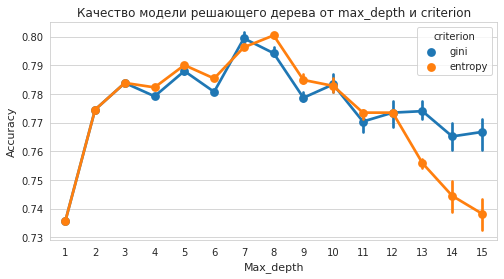

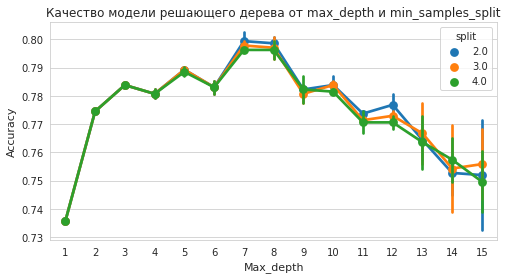

In [15]:
tree = tree.astype({'max_depth':'int'})

sns.set_style("whitegrid")
plt.figure(figsize=(8, 4))
b = sns.pointplot(data=tree, x='max_depth', y='accuracy', hue='criterion');
b.set_title('Качество модели решающего дерева от max_depth и criterion')
b.set_xlabel("Max_depth", fontsize=11)
b.set_ylabel("Accuracy", fontsize=11)
plt.show()

plt.figure(figsize=(8, 4))
b = sns.pointplot(data=tree, x='max_depth', y='accuracy', hue='split');
b.set_title('Качество модели решающего дерева от max_depth и min_samples_split')
b.set_xlabel("Max_depth", fontsize=11)
b.set_ylabel("Accuracy", fontsize=11)
plt.show()

### Случайный лес

In [16]:
best_forest_model = None
best_forest_result = 0
best_forest_est = 0
best_forest_depth = 0

forest = pd.DataFrame(columns= ['est','max_depth','accuracy'])

for est in range(10, 81, 10):
    for depth in range (1, 16):
        model = RandomForestClassifier(max_depth=depth, n_estimators=est, random_state=12345)
        accuracy = get_accuracy(model)
        forest = forest.append({'est':est,'max_depth':depth, 'accuracy':accuracy}, ignore_index=True)
        if accuracy > best_forest_result:
            best_forest_model = model
            best_forest_result = accuracy
            best_forest_depth = depth
            best_forest_est = est

print("Accuracy наилучшей модели случайного леса на валидационной выборке: {:.5f}".format(best_forest_result))
print("Глубина дерева:", best_forest_depth, "Est:", best_forest_est)

Accuracy наилучшей модели случайного леса на валидационной выборке: 0.81337
Глубина дерева: 9 Est: 10


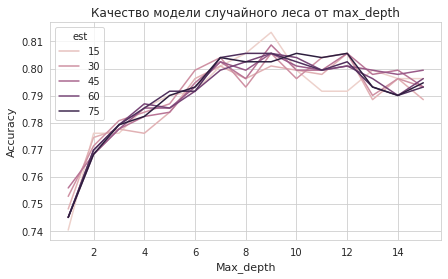

In [17]:
forest = forest.astype({'est':'int', 'max_depth':'int'})

plt.figure(figsize=(7, 4))
b = sns.lineplot(data=forest, x='max_depth', y='accuracy', hue='est');
#b.set_ylim(.73, 1.0)
b.set_title('Качество модели случайного леса от max_depth')
b.set_xlabel("Max_depth", fontsize=11)
b.set_ylabel("Accuracy", fontsize=11)
plt.show()

### Логистическая регрессия

In [18]:
best_log_model = None
best_log_result = 0
best_log_iter = 0

for iter in range(100, 1001, 100):
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
    accuracy = get_accuracy(model)
    if accuracy > best_log_result:
        best_log_model = model
        best_log_result = accuracy
        best_log_iter = iter

print("Accuracy наилучшей модели логистической регрессии на валидационной выборке: {:.4f}".format(best_log_result))
print("Максимальное кол-во итераций:", best_log_iter)

Accuracy наилучшей модели логистической регрессии на валидационной выборке: 0.7418
Максимальное кол-во итераций: 100


### Наилучшая модель

In [19]:
print("Дерево решений: Accuracy наилучшей модели на валидационной выборке: {:.4f}".format(best_tree_result))
print("max_depth:", best_tree_depth, ", criterion:", best_criterion, ", min_samples_split:", best_min_samples_split)
print()
print("Случайный лес: Accuracy наилучшей модели на валидационной выборке: {:.4f}".format(best_forest_result))
print("max_depth:", best_forest_depth, ", est:", best_forest_est)
print()
print("Логистическая регрессия: Accuracy наилучшей модели на валидационной выборке: {:.4f}".format(best_log_result))
print("max_iter:", best_log_iter)

Дерево решений: Accuracy наилучшей модели на валидационной выборке: 0.8025
max_depth: 7 , criterion: gini , min_samples_split: 2

Случайный лес: Accuracy наилучшей модели на валидационной выборке: 0.8134
max_depth: 9 , est: 10

Логистическая регрессия: Accuracy наилучшей модели на валидационной выборке: 0.7418
max_iter: 100


### Вывод по исследованию моделей

Исследованы модели: Дерево решений, Случайный лес, Логистическая регрессия:  

- `Дерево решений`: Accuracy наилучшей модели на валидационной выборке: 0.7994  
Гиперпараметры: max_depth: 7

- `Случайный лес`: Accuracy наилучшей модели на валидационной выборке: 0.8134  
Гиперпараметры: max_depth: 9 , est: 10

- `Логистическая регрессия`: Accuracy наилучшей модели на валидационной выборке: 0.6843  
Гиперпараметры: max_iter: 100

Ниалучшая точность на валидачионной выборке у модели `Случайный лес`.

## Проверьте модель на тестовой выборке

Проверим полученные лучшие модели.

In [20]:
# качество лучших моделей на валидационной выборке
accuracy_tree = best_tree_model.score(features_test, target_test) # (test_samples, true_labels)
accuracy_forest = best_forest_model.score(features_test, target_test)
accuracy_log = best_log_model.score(features_test, target_test)

print("Дерево: Accuracy на тестовой выборке: {:.4f}".format(accuracy_tree))
print("Случайный лес: Accuracy на тестовой выборке: {:.4f}".format(accuracy_forest))
print("Логистическая регрессия: Accuracy на тестовой выборке: {:.4f}".format(accuracy_log))
print()
print("Лучшая accuracy: {:.4f}".format(max(accuracy_tree, accuracy_forest, accuracy_log)))

Дерево: Accuracy на тестовой выборке: 0.7807
Случайный лес: Accuracy на тестовой выборке: 0.7838
Логистическая регрессия: Accuracy на тестовой выборке: 0.7558

Лучшая accuracy: 0.7838


### Вывод по проверке модели на тестовой выборке

Проверялась точность (accuracy) лучших полученных моделей из: дерево решений, случайный лес и логистическая регрессия.  
Полученные точности на тестовой выборке хуже, чем на валидационной выборке.  

- Дерево: Accuracy на тестовой выборке: 0.7823
- Случайный лес: Accuracy на тестовой выборке: 0.7854
- Логистическая регрессия: Accuracy на тестовой выборке: 0.7107  

Лучшая точность (accuracy) получена для **случайного леса**: `0.7854`

## (бонус) Проверьте модели на адекватность

Проверка модели на адекватность ведется по тестовой выборке.  

### Сравнение со случайной моделью
Для проверки адекватности модели (sanity check) сравним её со случайной.

In [21]:
# Оценка долей бинарных ответов в исходных данных
print("Клиентов Smart: {0}, клиентов Ultra: {1}. Доля Smart: {2:.2f}%. Доля Ultra: {3:.2f}%."
      .format(target_test.value_counts()[0]
              , target_test.value_counts()[1]
              , round((target_test.value_counts()[0] / target_test.shape[0]) * 100, 2)
              , round((target_test.value_counts()[1] / target_test.shape[0]) * 100, 2)))

Клиентов Smart: 454, клиентов Ultra: 189. Доля Smart: 70.61%. Доля Ultra: 29.39%.


Можно рассмотреть 3 случайных модели:  
   1. Случайная модель равномерно случайно выдаёт ответ 0 (тариф Smart) или 1 (тариф Ultra)
   2. Случайная модель всегда даёт только ответ 0 (тариф Smart)
   3. Случайная модель всегда даёт только ответ 1 (тариф Ultra)

Ожидаемые точности таких моделей:
   1. accuracy ~ 0.5
   2. accuracy ~ 0.7061
   3. accuracy ~ 0.2939

In [22]:
# Модель 1 - равномерно случайно выдаёт ответ 0 (тариф Smart) или 1 (тариф Ultra)
def randon_predictions(size):
    return np.random.randint(low= 0, high= 2, size= size)

random1_predictions = randon_predictions(target_test.shape[0])

# Модель 2 - выдаёт всегда значения 0 (тариф Smart)
random2_predictions = np.full(shape= target_test.shape[0], fill_value= 0, dtype= 'int')

# Модель 3 - выдаёт всегда значения 1 (тариф Ultra)
random3_predictions = np.full(shape= target_test.shape[0], fill_value= 1, dtype= 'int')

random1_accuracy = accuracy_score(target_test, random1_predictions)
random2_accuracy = accuracy_score(target_test, random2_predictions)
random3_accuracy = accuracy_score(target_test, random3_predictions)

print("Точность случайной модели №1: {:.4f}".format(random1_accuracy))
print("Точность случайной модели №2: {:.4f}".format(random2_accuracy))
print("Точность случайной модели №3: {:.4f}".format(random3_accuracy))

Точность случайной модели №1: 0.4635
Точность случайной модели №2: 0.7061
Точность случайной модели №3: 0.2939


Наилучшую точность среди случайных моделей даёт модель, выдающая значения 0 (тариф Smart).  
Точность случайной модели №2: 0.7061  
Перевес значений 0 в обучающей выборке может влиять на обучение модели.  
Очевидно, что модель должна быть не хуже этой случайной модели.

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def ShowConfusionMatrix(predictions):
    cm = confusion_matrix(target_test, predictions)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_forest_model.classes_)
    disp.plot()
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    print("true negatives: ", tn, "false positive:", fp)
    print("false negatives: ", fn, "true positive:", tp)

Модель 1 - равномерно случайно выдаёт ответ 0 (тариф Smart) или 1 (тариф Ultra)


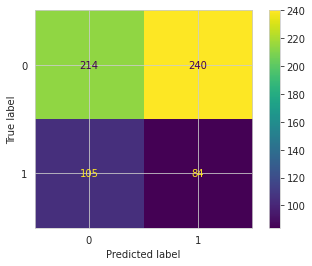

true negatives:  214 false positive: 240
false negatives:  105 true positive: 84


In [38]:
print("Модель 1 - равномерно случайно выдаёт ответ 0 (тариф Smart) или 1 (тариф Ultra)")
ShowConfusionMatrix(random1_predictions)

Модель 2 - выдаёт всегда значения 0 (тариф Smart)


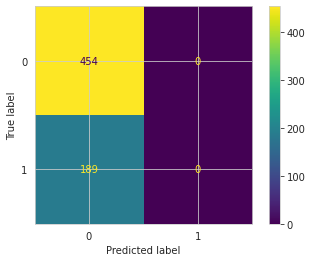

true negatives:  454 false positive: 0
false negatives:  189 true positive: 0


In [39]:
print("Модель 2 - выдаёт всегда значения 0 (тариф Smart)")
ShowConfusionMatrix(random2_predictions)

 Модель 3 - выдаёт всегда значения 1 (тариф Ultra)


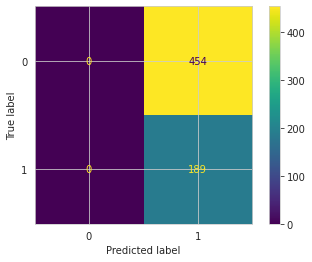

true negatives:  0 false positive: 454
false negatives:  0 true positive: 189


In [41]:
print(" Модель 3 - выдаёт всегда значения 1 (тариф Ultra)")
ShowConfusionMatrix(random3_predictions)

Дополнительно оценим **Precision** лучшей модели для знаяения 0 (тариф Smart) на тестовой выборке.

In [24]:
# Выделение из тестовой  выборки только тарифа Smart (is_ultra = 0)

# Слияние features, targets
# print(features_test.shape[0])
test_smart = pd.concat([features_test, target_test], axis= 1)
# print(test_smart.shape[0])
test_smart = test_smart.query('is_ultra == 0')
# print(test_smart.shape[0])

# Разделение на features, targets
features_test_smart = test_smart.drop('is_ultra', axis= 1)
target_test_smart = test_smart['is_ultra']

In [25]:
precision_smart = best_forest_model.score(features_test_smart, target_test_smart)
print("Precision лучшей модели для тарифа Smart: {:.4f}".format(precision_smart))

Precision лучшей модели для тарифа Smart: 0.9185


In [26]:
# Precision случайной модели
random2_smart_predictions = randon_predictions(target_test_smart.shape[0])
precision_random_smart = accuracy_score(target_test_smart, random2_smart_predictions)
print("Precision случайной модели для тарифа Smart: {:.4f}".format(precision_random_smart))

Precision случайной модели для тарифа Smart: 0.5374


### Вывод по проверке адекватности модели

Сравниваем лучшую модель со случайной моделью, дающую наилучную точность.  
Полученные значения Accuracy:

- Лучшая модель - Случайный лес: Accuracy на тестовой выборке: 0.7854
- Точность случайной модели №2 (всегда предсказывает 0(тариф Smart)): 0.7061

Сравнение Precision лучшей модели и случайной модели:
- Precision лучшей модели для тарифа Smart: 0.9185
- Precision случайной модели для тарифа Smart: 0.5352 (ожидаемое ~0.5)

**Вывод:** Полученная модель имеет лучшую точность, чем случайная. Значит, модель адекватна.

## Общий вывод

**Вывод по общим данным файла**  

Данные содержат 3214 записи.  
Наименования столбцов корректны.  
Пропущенных данных не обнаружено. 
Типы данных корректны.  
Полных (явных) дубликатов не обнаружено.  

**Описание данных**  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц.  
Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

**Вывод по выделенным признакам**  

Выбранные признаки имеют различия в характере распределения. Имеют отличающиеся статистики. Также, все имеют слабую положительную корреляцию с целевым признаком.  

Наличие пусть и слабой корреляции делает обоснованным выбор признаков для обучения модели.  

Пропорция целевых признаков 0 и 1 в исходной выборке не 50% на 50%, а перевешивает в пользу 0 (тариф Smart).  

**Вывод по разбивке данных на выборки**  

Данные разбиты в пропорциях:
- Обучающую - 60%
- Валидационную - 20%
- Тестовую - 20%

**Вывод по исследованию моделей**  

Исследованы модели: Дерево решений, Случайный лес, Логистическая регрессия:  

- `Дерево решений`: Accuracy наилучшей модели на валидационной выборке: 0.7994  
Гиперпараметры: max_depth: 7

- `Случайный лес`: Accuracy наилучшей модели на валидационной выборке: 0.8134  
Гиперпараметры: max_depth: 9 , est: 10

- `Логистическая регрессия`: Accuracy наилучшей модели на валидационной выборке: 0.6843  
Гиперпараметры: max_iter: 100

Ниалучшая точность на валидачионной выборке у модели `Случайный лес`.

**Вывод по проверке модели на тестовой выборке**  

Проверялась точность (accuracy) лучших полученных моделей из: дерево решений, случайный лес и логистическая регрессия.  
Полученные точности на тестовой выборке хуже, чем на валидационной выборке.  

- Дерево: Accuracy на тестовой выборке: 0.7823
- Случайный лес: Accuracy на тестовой выборке: 0.7854
- Логистическая регрессия: Accuracy на тестовой выборке: 0.7107  

Лучшая точность (accuracy) получена для **случайного леса**: `0.7854`

**Вывод по проверке адекватности модели**  

Сравниваем лучшую модель со случайной моделью, дающую наилучную точность.  
Полученные значения Accuracy:

- Лучшая модель - Случайный лес: Accuracy на тестовой выборке: 0.7854
- Точность случайной модели №2 (всегда предсказывает 0(тариф Smart)): 0.7061

Сравнение Precision лучшей модели и случайной модели:
- Precision лучшей модели для тарифа Smart: 0.9185
- Precision случайной модели для тарифа Smart: 0.4802 (ожидаемое ~0.5)

Полученная модель имеет лучшую точность, чем случайная. Значит, модель адекватна.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
